# Deep Learning with Pytorch

Let's load in any libraries we will use in this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms

#this is a nice progress bar representation that will be good to measure progress during training
import tqdm

# Elements of Training a Deep Neural Network

As we covered in the lecture, there are four key elements to training a deep neural network:
1. **The dataset**: We are performing supervised learning. That means we need a set of data with inputs and ground-truth outputs.
2. **The model**: The deep neural network that we want to perform prediction on our data
3. **A loss function**: A function that given a prediction from our model, compares it to the ground-truth output and indicates how "bad" the prediction is.
4. **Stochastic Gradient Descent**: This algorithm takes the information from the loss function, and uses it to decide how to update the model parameters so that the loss function reduces.

We are going to cover each of these in this tutorial, when we train a deep neural network for identifying pneumonia in chest X-rays.



# Ingredient 1: The Data

First, let's extract our data from the zip file and visually inspect it to get an understanding of the structure.

To unzip the file, right click the zip and select 'Extract Archive'. Allow about a minute for the extraction.


## Loading the dataset into Pytorch

When we have a classification dataset structured in this way, there is a very nice in-built torchvision function that we can use to load it: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html 

The ImageFolder dataset class nicely loads in the images in each folder, extracting the respective 'ground-truth' classes based on the name of the folder they are located inside. Images are loaded in using the PIL (pillow) library and will be stored in that format.

Torchvision also has a lot of in-built datasets that you can easily load and work with (for your interest) -- https://pytorch.org/vision/main/datasets.html

Notice that the ImageFolder dataset also can take in a **transform**. This will get applied to the raw data that is loaded from our dataset directory. There is always 2 transforms that we should consider when using images with Pytorch:
1. **converting the data to a Tensor**: this is the format that all data needs to be in before using the Pytorch library. See documentation [here](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.ToTensor).
2. **normalizing the data**: We know that lots of ML works better when given normalised input features -- this is the same for deep neural networks! See documentation [here](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Normalize).

In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(), #we're using grayscale images today to simplify, you likely won't need this in future
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
    ])

trainval_dataset = torchvision.datasets.ImageFolder('chest_xray/trainval', transform = transform)
test_dataset = torchvision.datasets.ImageFolder('chest_xray/test', transform = transform)

There are a number of fields we can grab out of the ImageFolder dataset class, including:
* self.classes = classes
* self.class_to_idx = class_to_idx
* self.samples = samples
* self.targets = [s[1] for s in samples]

Try printing these below to see what they hold.

## Creating Data Subsets

We now need to separate out our trainval dataset into a single train dataset and val dataset.

We can still use the sklearn [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to do this! Rather than passing in the entire dataset, we will pass in a list of indices as large as the dataset and split this.

We can then combine this with the [torch.utils.data.Subset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) class which can create subsets of datasets given the indices in relation to the total dataset.

In [ ]:
train_portion = 0.8
val_portion = 0.2

all_idxes = np.arange(len(trainval_dataset))
all_targets = trainval_dataset.targets

train_idx, val_idx = train_test_split(all_idxes, train_size=train_portion, stratify = all_targets, random_state = 0)


train_dataset = torch.utils.data.Subset(trainval_dataset, train_idx)
val_dataset = torch.utils.data.Subset(trainval_dataset, val_idx)


print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of val dataset: {len(val_dataset)}')
print(f'Size of test dataset: {len(test_dataset)}')


## Inspecting the Data

There's one major take-away here: a neural network needs a vector of input values, but an image is a matrix of pixels (we'll learn more about this next week).
For now, we're going to flatten that matrix into one long vector of pixel values -- weird right? But you'll be suprised at how well the neural network can learn from this.

In [ ]:
fig, ax = plt.subplots(2, 4)
for idx in range(4):
    train_image = (train_dataset[idx][0].numpy().reshape((28, 28))*255)+125
    ax[0, idx].imshow(train_image, cmap = 'gray')
    network_input = train_image.reshape(1, -1)
    ax[1, idx].imshow(network_input, cmap = 'gray', aspect='auto')

    ax[0, idx].set_axis_off()
    ax[1, idx].set_axis_off()
    
ax[0, 1].set_title('Images from dataset')
ax[1, 1].set_title('Input to the network -- a vector of pixel values')
plt.show()

print('Example input to the network without visualisation (first 100 values):')
print(train_dataset[0][0].flatten()[:100])

input_size = len(train_dataset[0][0].flatten())
print(f'Size of input: {input_size}')

## Creating dataloaders

Dataloaders are Pytorch's useful way of handling data. They automatically batch the dataset into the batch size you want, and can also randomly shuffle the data for you if you choose. They nicely handle the dataset for us during training and testing.

1. *torch.utils.data.DataLoader()* You can read the documentation here: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    1. First argument is the dataset.
    2. Optional argument *batch_size* is the batch size to test the model with. How many data points will the model be tested on in parallel?
    3. Optional argument *shuffle* controls whether data is randomly shuffled before taking from the dataset.
    4. Optional argument *num_workers* is how many subprocesses are used to load data from the dataset -- it can make loading the data faster.

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers = 2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers = 2)

# Ingredient 2: The Model

In this section, I'm going to show you how to build a neural network with 1 hidden layer. Most of the code is done for you, but make sure to read through and understand what's going on, because in the next part you'll be following this process to create a deep neural network!

## Building the network
In the cell below, there's a class called *LinearClassifier*.     
This is a simple linear classifier, which has no non-linearity and is the basic building block of many deep neural networks.

The class definitions for a PyTorch model generally follow this minimum structure:
1. an **\__init__()** function where we create the model architecture.
    1. **nn.Linear** creates a layer of linear neurons (no activation function - yet). This will be initialised with a weights vector of size nxm, where n is the size of the input to the layer, and m is the output size of the layer (i.e. number of neurons in the layer).  
    Note the input arguments -- the first argument is the input size, the second argument is the number of neurons in the layer. I've initialised the first layer with an input_size of 784 -- above, we saw that was the size of an image when it was flattened to a vector. It has an output size of 2 because we have 2 classes.
    Read more about this layer type here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
2. a **foward()** function where we pass an input through our model and return its output.
    1. In the \__init__ function, we created the layers that make our architecture. Now we must apply them.

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 2)
       
        
    def forward(self, x):
        y = self.fc(x)
       
        return y

Now that we've defined the network, let's create an instance of it. We're also *hopefully* using a GPU node at the moment, so we'll load the network onto the GPU if we are. If not, don't worry -- the network will stay on the CPU.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available

net = LinearClassifier()
net.to(device)

print(net)

We can look at the parameters of the certain layers of the model by accessing the 'weight' and 'bias' field of a layers

# Ingredient 3: Creating a loss function

We're going to use Cross Entropy Loss (a very standard loss for classification tasks).

1. *nn.CrossEntropyLoss* - plain Cross Entropy Loss. You can read the documentation here: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
loss_fn = nn.CrossEntropyLoss()

# Ingredient 4: Creating a Stochastic Gradient Descent Optimizer

We're going to use Stochastic Gradient Descent, where we perform gradient descent over batches of the dataset (not the entire dataset). 

One thing to note: because Stochastic Gradient Descent is going to calculate the gradients on our model parameters, and it's also going to update these, we need to link it to the model parameters like you can see below.

1. *optim.SGD* - stochastic gradient descent! Documentation here: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    1. It will work with however many examples you pass in (anywhere from 1 - entire dataset). 

In [ ]:
optimizer = optim.SGD(net.parameters())

# Finally: Time to train our model!

In the lecture, we learnt that we train our model by:
1. Define a loss function (or cost function or objective).
2. Pick initial values for W and b.
3. Until satisfied (e.g. loss converged/stops changing):
    1. Perform a forward pass to find a prediction.
    2. Calculate the loss
    3. Perform a backward pass to calculate loss gradients with respect to the parameters.
    4. Update the parameters based on the loss gradients.

We're going to build those things up, one at a time, in the cell below. **If you are completing this on your own, it is highly recommended you access the recording.**

In [ ]:
torch.manual_seed(0) #so that each time we run this cell the trainloader shuffle acts in same way


# Deep Neural Networks
## Build a better model
Building off the code from above, we're going to create a deep neural network with at least 4 fully connected layers.

We're going to add additional layers and non-linearities (in the form of ReLU activation functions) into our network. See documentation here: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html 

In [ ]:
#### Update this model #####

class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 2)
       
        
    def forward(self, x):
        y = self.fc(x)
       
        return y

        

## Using the training code from above, train your Deep Neural Network!

# Evaluate your best model on the test dataset
Test for accuracy on the test dataset.

Also create a confusion matrix to visualise the predictions.

# Going deeper with Convolutional Neural Networks

If you’d like to explore further, you can use the code below (VGG model) to train a CNN on our dataset. We’ll cover CNNs in more detail next week, but you’re welcome to run it now.

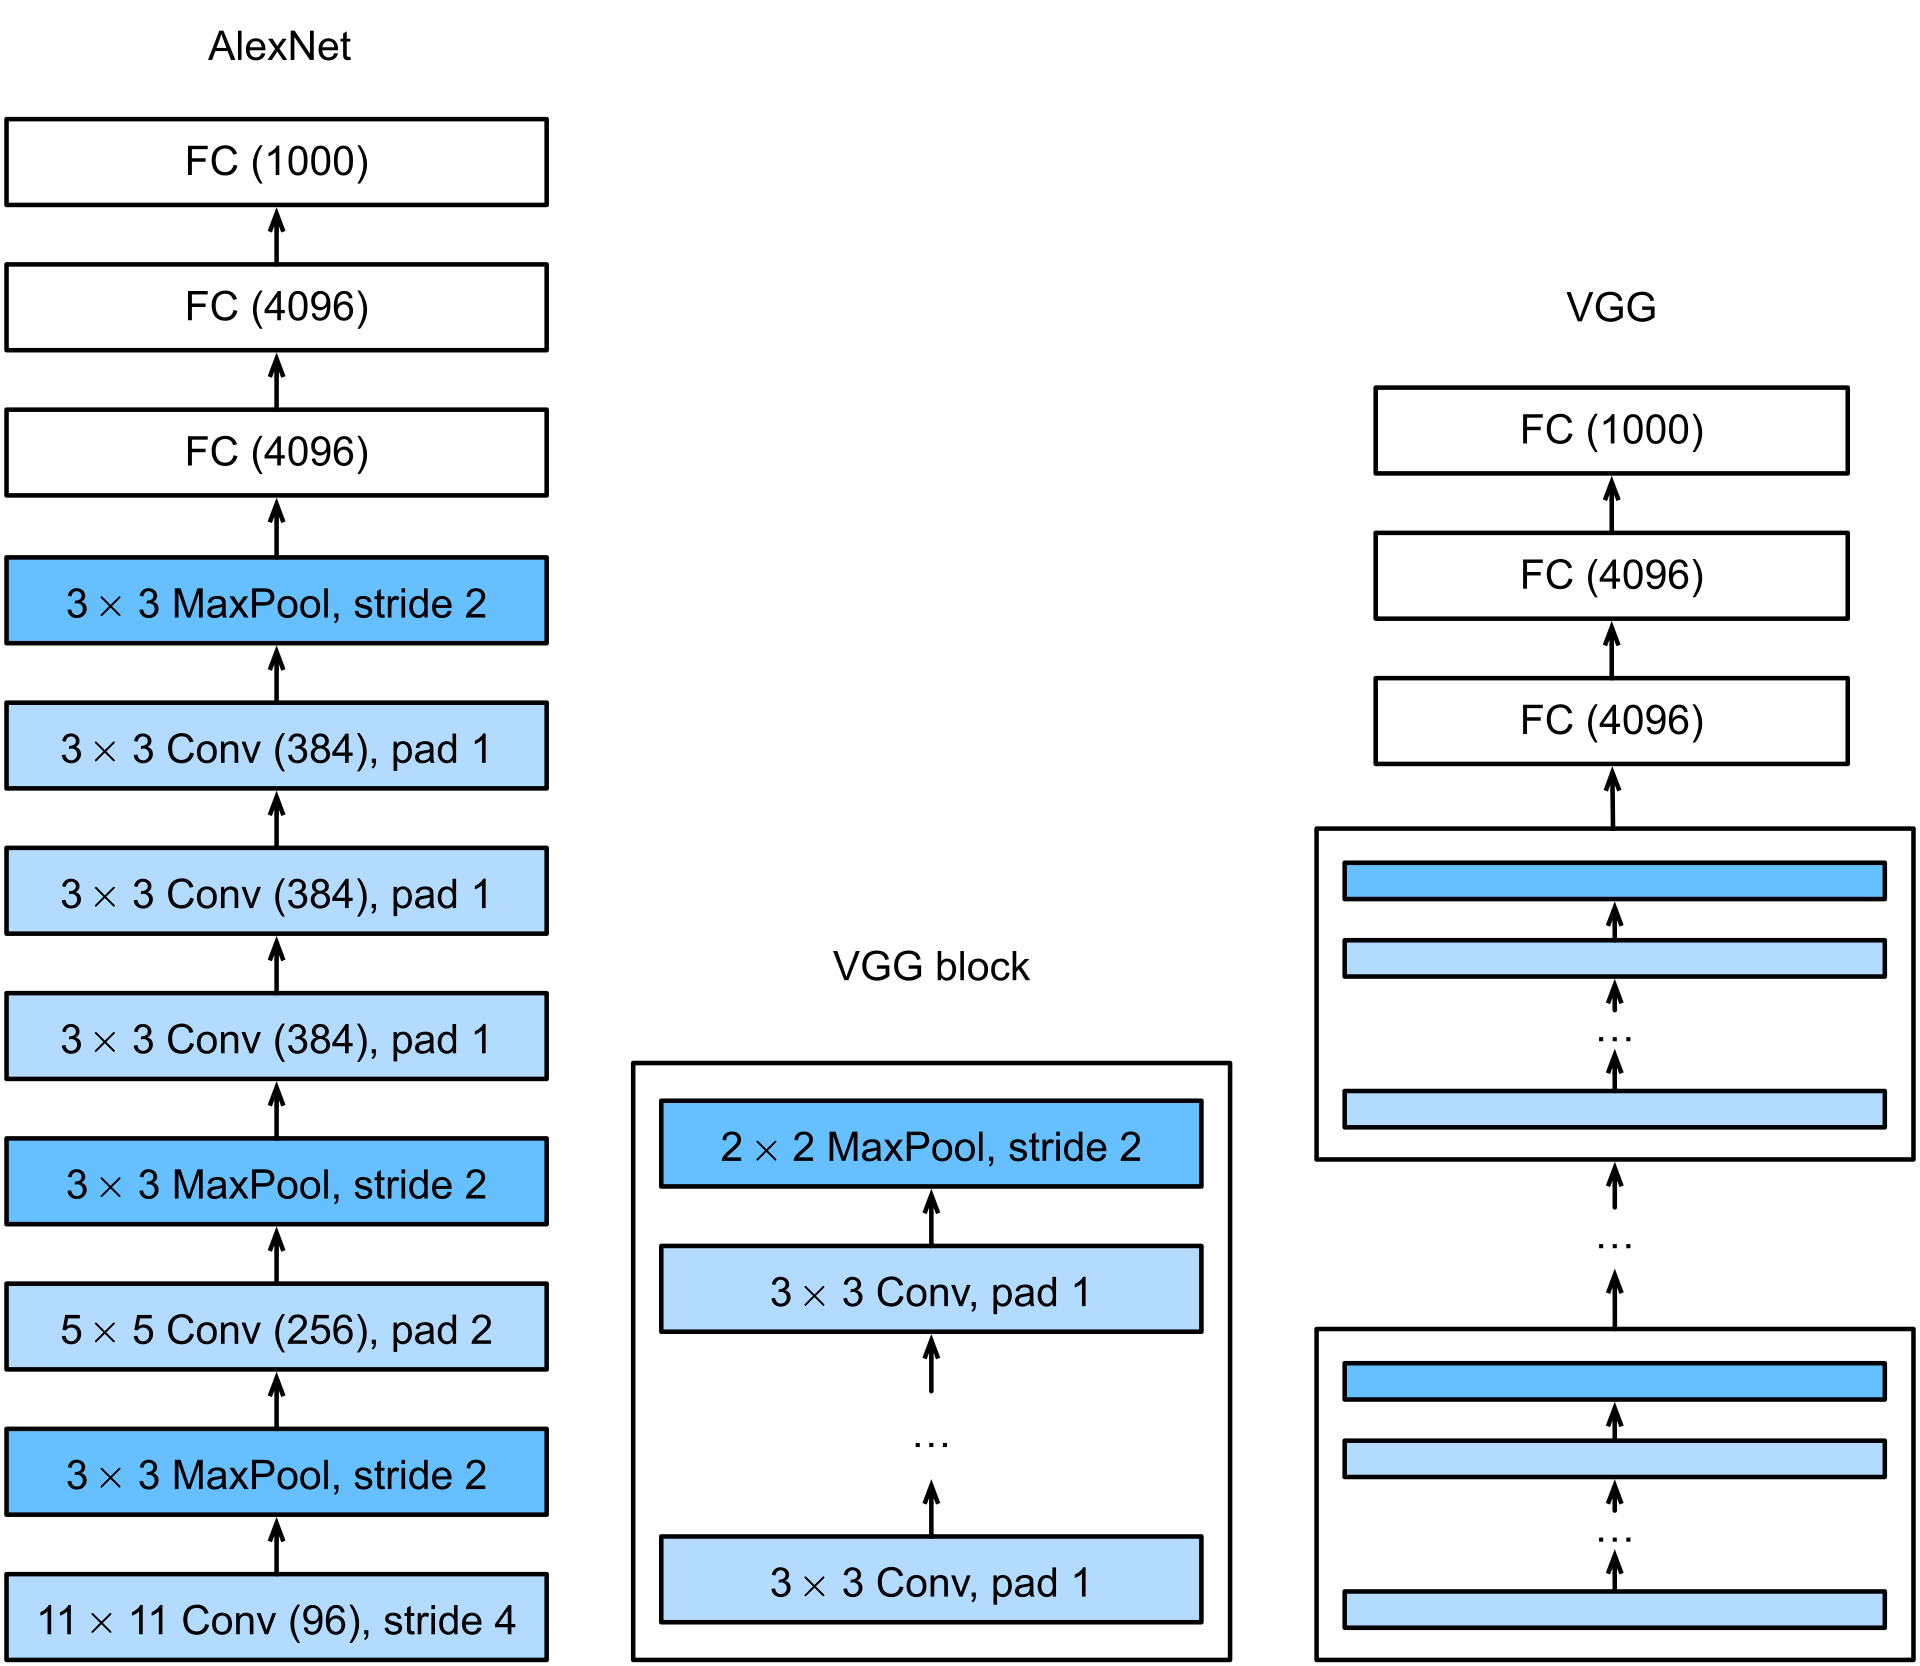

In [ ]:
class VGG(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x